Emmanuel Arias Polanco
## __Problema N cuerpos__

Dadas las ecuaciones de movimiento para $N$ partículas

$$m_i\boldsymbol{\ddot{x}_{i}} = -G m_i \sum_{j=1,j\neq i}^{N} \frac{m_j}{|\boldsymbol{x_{ij}}|^3} \boldsymbol{\hat{x}_{ij}}$$

Donde $\boldsymbol{x_{ij}} = \boldsymbol{x_i} - \boldsymbol{x_j}$ es el vector que apunta desde la partícula $j$ a la partícula $i$, implementar un método RK4 para solucionar las ecuaciones de movimiento.

## __Solución__

Para solucionar el problema, debemos reducir el problema a un sistema de ecuaciones lineales. Para esto, definimos $\boldsymbol{\dot{x}_i} = \frac{d\boldsymbol{x_i}}{dt} = \boldsymbol{v_i}$, con lo cual se tiene el conjunto de ecuaciones

$$\boldsymbol{\dot{x}_i} = \boldsymbol{v_i}$$
$$\boldsymbol{\dot{v}_i} = -G\sum_{j = 1, j \neq i}^{N} \frac{m_j}{|\boldsymbol{x_{ij}}|^3} \boldsymbol{\hat{x}_{ij}}$$

Que representa, en general, para un problema tridimensional, un sistema de $6N$ ecuaciones, $3$ de posición y $3$ de velocidad para cada partícula. Para obtener este sistema, en general para el caso bidimensional y tridimensional, implementamos la función ```ODEs()```

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time

In [2]:
def ODEs(t, q, mass, G = 4 * np.pi**2):
    '''
    Definition of the system of equations for the general N-body problem. The
    function returns an array with the same shape as q (2D), where each row of
    the array contains position and velocity equations for each particle (4
    equations in case of 2D problem, 6 equations in case of 3D problem)
    ----------------------------------------------------------------------------
    Arguments:
    ----------------------------------------------------------------------------
    t: time evolution variable
    q: array of initial conditions it is related to the number of variables
    involved in the system of equations after the linealization. If the problem
    is 3D then the array is of shape (N,6) where N is the number of particles,
    and there are 6 variables x,y,z,vx,vy,vz.
    If 2D, the the shape is (N,4)
    mass: 1D array of masses for each particle in the array, size of the array is N
    G: value of the gravitational constant, default: 4pi^2 (in terms of solar 
    masses, years and astronomical units)
    '''

    shape = q.shape
    N = len(mass)
    dim = int(shape[1]/2)
    system = np.zeros(shape)

    system[:,:dim] = q[:,dim:] # differential equations for velocity

    for ii in range(0,N):
        auxr = q[ii,:dim] - q[:,:dim]
        r = np.sqrt(np.sum(auxr*auxr, axis = 1)) # axis = 1 sums over columns
        r[ii] = 1 # sets the ii-th element to 1 in order to avoid division by zero
        # system[ii,:dim] = q[ii,dim:] # <- it's better to not to call many objects in the loop, in order to achieve perfomance
        
        for jj in range(0,dim):
            system[ii,jj + dim] = -G * np.sum(mass * auxr[:,jj] / r**3)

    return system


Para solucionar este sistema, usaremos incialmente el método Runge-Kutta de orden 3 (RK4)

In [3]:
def RK4_step(ODEs, t0, q0, mass, h):
    '''performs a single step of length dt using the RK4 method'''
    k1 = h*ODEs(t0, q0, mass)
    k2 = h*ODEs(t0 + h/2, q0 + k1/2, mass)
    k3 = h*ODEs(t0 + h/2, q0 + k2/2, mass)
    k4 = h*ODEs(t0 + h, q0 + k3, mass)

    return q0 + (k1 + 2*k2 + 2*k3 + k4)/6

def solver(ODEs, t0, tf, q0, mass, h, method = 'rk4'):
    '''
    Makes the principal loop
    ----------------------------------------------------------------------
    Arguments:
    ----------------------------------------------------------------------
    ODEs: system of linear differential equations to solve
    t0, tf: interval where the loop is going to be excecuted
    q0: array with initial conditions of shape (N,2*dim), where N is the
    number of particles, and dim is the dimentionality of the problem
    mass: array with masses for each particle
    h: step size for each iteration in the RK4 method
    '''

    steps = int((tf-t0)/h)
    shape = q0.shape

    sol = np.zeros((steps, shape[0], shape[1]))
    t_grid = np.linspace(t0,tf,steps)

    for ii in range(0,shape[1]): 
        # fills the first layer of the array with the initial values for
        # each particle
        sol[0,:,ii] = q0[:,ii]

    if method == 'rk4':
        for ii in range(0,steps - 1):
            sol[ii + 1] = RK4_step(ODEs, t_grid[ii], sol[ii], mass, h)

    elif method == 'verlet':
        sol[1,:,:3] = RK4_step(ODEs, t_grid[0], sol[0], mass, h)[:,:3]
        for ii in range(1,steps - 1):
            sol[ii+1,:,:3] = 2.*sol[ii,:,:3] - sol[ii - 1,:,:3] + ODEs(t_grid[ii], sol[ii], mass)[:,3:]*h**2 # possition step
            sol[ii,:,3:] = (sol[ii + 1,:,:3] - sol[ii - 1,:,:3])/(2*h) # velocity step
        
        sol[-1,:,3:] = RK4_step(ODEs, t_grid[-2], sol[-2], mass, h)[:,3:]

    else:
        raise ValueError("The method specified it's not an implemented solving algorithm")

    return sol

def TotalEnergy(q, m, G = 4*np.pi**2):
    shape = q.shape
    dim = int(shape[1]/2)

    vsqr = np.sum(q[:,dim:]*q[:,dim:], axis = 1)
    E_c = np.sum(0.5*m*vsqr)

    E_g = 0

    for ii in range(0, q.shape[0]):
        auxr = q[ii,:dim] - q[:,:dim]
        r = np.sqrt(np.sum(auxr*auxr, axis = 1)) # axis = 1 sums over columns
        r[ii] = 1e300

        # mr = m/r
        E_g += -0.5*G*m[ii]*np.sum(m/r)

    return E_c + E_g

Con esta implementación, podemos solucionar problemas gravitacionales para $N$ partículas, como se hace a continuación

#### __Sistema tierra - sol__

In [4]:
data_path = 'data/sun_earth.dat'

# =======================================data reading=====================================
data = np.genfromtxt(data_path, dtype = 'float', comments= '#', unpack = False)

# convertion of units to a convenient sistem of units based on solar masses, years and astromical units
m_sun = 1.98855e30
au_m = 1.49598261e11
year_s = 3600*24*365

data[:,:3] = data[:,:3]/au_m
data[:,3:6] = data[:,3:6]*year_s/au_m
data[:,-1] = data[:,-1]/m_sun

df = pd.DataFrame(data, columns = ['x', 'y', 'z', 'v_x', 'v_y', 'v_z', 'mass'])
df

,x,y,z,v_x,v_y,v_z,mass
0,0.0,0.0,0.0,0.0,0.000000,0.0,1.000000
1,1.0,0.0,0.0,0.0,6.277761,0.0,0.000003


In [5]:
# orbit for five years and 40000 steps
t0 = 0
tf = 5
steps = 40000
dt = (tf-t0)/steps
print(f'Resolution: {dt} (approx {dt*24*365:.2f} hours)')

t_grid = np.linspace(t0,tf,steps)

q = np.zeros((steps, data[:,:6].shape[0], data[:,:6].shape[1]))

sol = solver(ODEs, t0, tf, data[:,:6], data[:,-1], dt)
# sol = solver(ODEs, t0, tf, data[:,:6], data[:,-1], dt, method = 'verlet')

Resolution: 0.000125 (approx 1.09 hours)


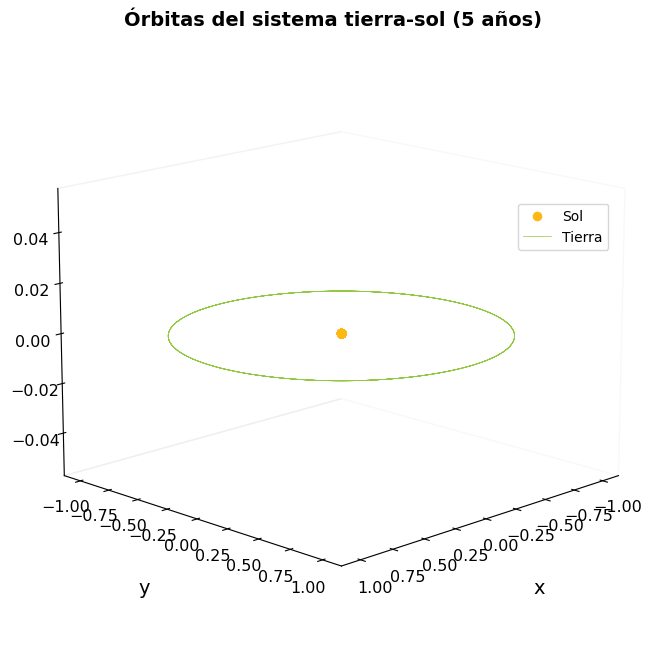

In [6]:
fig = plt.figure(figsize = (8,8))
ax = plt.axes(projection='3d')
ax.grid(False)

ax.set_title(f'Órbitas del sistema tierra-sol ({tf-t0} años)', fontweight = 'bold', fontsize = 14)

common_size = 14
common_lsize = 11.5
ax.set_xlabel('x', labelpad=20, fontsize = common_size)
ax.set_ylabel('y', labelpad=20, fontsize = common_size)
ax.set_zlabel('z', labelpad=20, fontsize = common_size)
ax.tick_params(axis='x', which='both', labelsize=common_lsize)
ax.tick_params(axis='y', which='both', labelsize=common_lsize)
ax.tick_params(axis='z', which='both', labelsize=common_lsize)

# ax.set_facecolor('black')
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

ax.scatter3D(sol[:,0,0], sol[:,0,1], sol[:,0,2], label = 'Sol', s = 35, c = '#FDB813')
ax.plot3D(sol[:,1,0], sol[:,1,1], sol[:,1,2], label = 'Tierra', lw = .5, c = '#92c842')

ax.view_init(elev = 15, azim = 45)
ax.legend(loc = (.8,.65))

# plt.savefig('figures/eart-sun.pdf')

Si graficamos la energía, podemos apreciar que esta se conserva a lo largo de la integración

In [7]:
energy = np.zeros(sol.shape[0])

for ii in range(sol.shape[0]):
    energy[ii] = TotalEnergy(sol[ii,:,:],data[:,-1])

print(f'Initial energy: {energy[0]}')
print(f'Change in energy: {np.abs(energy[0] - energy[-1])} ({100*(np.abs(1-energy[-1]/energy[0])):.2e}%)')

Initial energy: -5.938486508970787e-05
Change in energy: 2.3174821436877657e-18 (3.91e-12%)


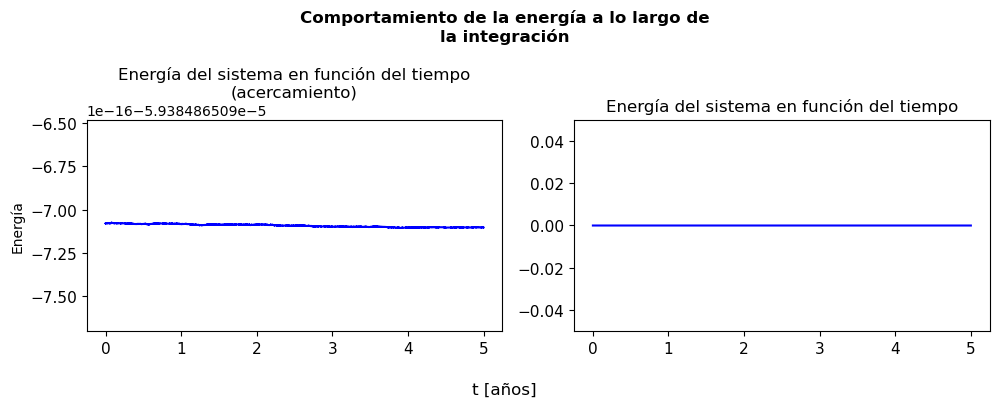

In [8]:
fige, axe = plt.subplots(1,2, figsize = (10,4))

fige.suptitle('Comportamiento de la energía a lo largo de\nla integración', fontweight = 'bold', fontsize = 12)
fige.supxlabel('t [años]')

axe[0].set_title('Energía del sistema en función del tiempo\n(acercamiento)')
axe[0].set_ylabel('Energía')
axe[0].tick_params(axis='both', which='both', labelsize=11)
axe[0].plot(t_grid, energy, c = 'b')

axe[1].set_title('Energía del sistema en función del tiempo')
axe[1].set_ylim(-0.05,0.05)
axe[1].tick_params(axis='both', which='both', labelsize=11)
axe[1].plot(t_grid, energy, c = 'b')

plt.tight_layout()
# plt.savefig('figures/eart-sun_energy.pdf')

#### __Clúster de Sagitario A*__

El agujero negro supermasivo en el centro de La Vía Láctea, Sagitario A*, se encuentra en órbita -corta- con un cluster de estrellas llamado el Clúster de Sagitario A*. Las posiciones y velocidades lineales de 13 estrellas, para determinado momento en su órbita, se encuentran en el archivo ```S0stars.dat```. La simulación del sistema se hace a continuación

In [9]:
data_path = 'data/S0stars.dat'

# =======================================data reading=====================================
dataBH = np.genfromtxt(data_path, dtype = 'float', comments= '#', unpack = False)

# convertion of units 
arcsec_au = 8000

dataBH[:,:3] = dataBH[:,:3]*arcsec_au
dataBH[:,3:6] = dataBH[:,3:6]*arcsec_au
dataBH[:,-1] = dataBH[:,-1]

df = pd.DataFrame(dataBH, columns = ['x', 'y', 'z', 'v_x', 'v_y', 'v_z', 'mass'])
df

,x,y,z,v_x,v_y,v_z,mass
0,0.000,0.000,0.000,0.0,0.0,0.000,4300000.0
1,-1195.504,546.936,-822.232,15.0,-278.0,-285.600,1.0
2,-231.904,1317.736,1074.664,-90.6,-43.2,35.000,1.0
3,1131.352,808.416,-3267.400,152.4,40.8,248.600,1.0
4,2076.960,-1110.424,2471.608,149.6,-135.2,216.000,1.0
5,1365.144,-2106.272,-2764.896,30.8,-119.0,239.000,1.0
6,839.264,-3250.912,3529.064,-43.2,15.4,190.600,1.0
7,-2678.632,3089.936,747.232,11.2,-92.6,-163.400,1.0
8,1528.592,1377.848,-504.824,-156.4,-125.0,102.000,1.0
9,-247.832,-1865.240,9.440,34.0,-28.2,-376.600,1.0


In [10]:
t0 = 0
tf = 200
steps = 40000
dt = (tf-t0)/steps
print(f'Resolution: {dt} (approx {dt*24*365:.2f} hours)')

t_grid = np.linspace(t0,tf,steps)

startBH = time.time()
solBH = solver(ODEs, t0, tf, dataBH[:,:6], dataBH[:,-1], dt)
endBH = time.time()
print(f'El tiempo de ejecución fue {endBH - startBH} segundos')

Resolution: 0.005 (approx 43.80 hours)
El tiempo de ejecución fue 59.905503273010254 segundos


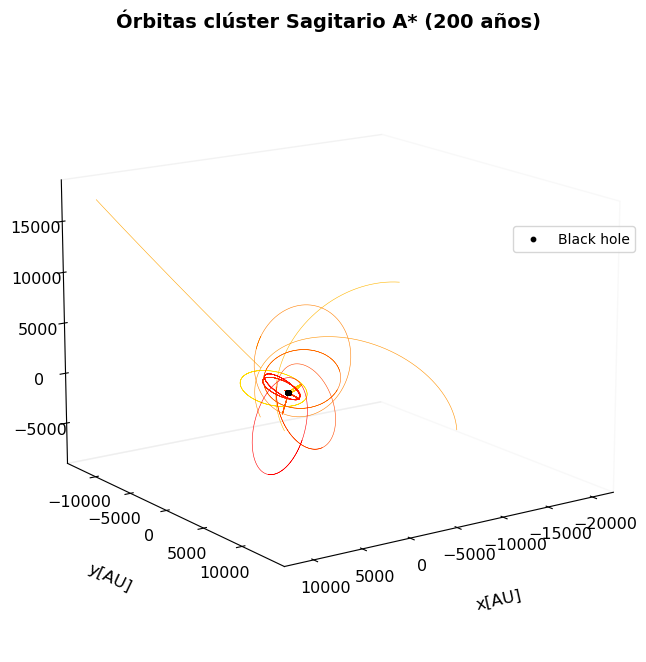

In [11]:
import matplotlib.colors as mpc

fig = plt.figure(figsize = (8,8))
ax = plt.axes(projection='3d')
ax.grid(False)

ax.set_title(f'Órbitas clúster Sagitario A* ({tf-t0} años)', fontweight = 'bold', fontsize = 14)

common_size = 12
common_lsize = 11.5
ax.set_xlabel('x[AU]', labelpad=20, fontsize = common_size)
ax.set_ylabel('y[AU]', labelpad=20, fontsize = common_size)
ax.set_zlabel('z[AU]', labelpad=20, fontsize = common_size)
ax.tick_params(axis='x', which='both', labelsize=common_lsize)
ax.tick_params(axis='y', which='both', labelsize=common_lsize)
ax.tick_params(axis='z', which='both', labelsize=common_lsize)

# ax.set_facecolor('black')
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

ax.scatter3D(solBH[:,0,0], solBH[:,0,1], solBH[:,0,2], label = 'Black hole', c = 'k', s = 10)

cmap = plt.get_cmap("autumn_r", 15)
col = [mpc.rgb2hex(cmap(i)) for i in range(cmap.N)]

for ii in range(1,len(dataBH[:,-1])):
    # ax.plot3D(solBH[:,ii,0], solBH[:,ii,1], solBH[:,ii,2], label = str(ii))
    ax.plot3D(solBH[:,ii,0], solBH[:,ii,1], solBH[:,ii,2], c = col[ii + 1], lw = .4)

ax.view_init(elev = 15, azim = 55)
ax.legend(loc = (.8,.65))
# plt.savefig('figures/sA*.pdf')

Para este sistema, la energía se comporta como

In [12]:
energyBH = np.zeros(solBH.shape[0])

for ii in range(solBH.shape[0]):
    energyBH[ii] = TotalEnergy(solBH[ii,:,:],dataBH[:,-1])

print(f'Initial energy: {energyBH[0]}')
print(f'Change in energy: {np.abs(energyBH[0] - energyBH[-1])} ({100*(np.abs(1-energyBH[-1]/energyBH[0])):.2e}%)')

Initial energy: -460128.30167210556
Change in energy: 4009.876249781344 (8.71e-01%)


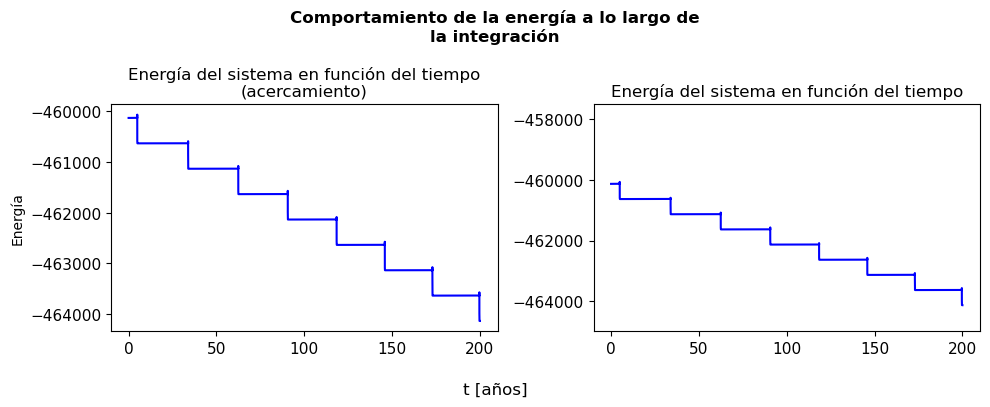

In [13]:
figeBH, axeBH = plt.subplots(1,2, figsize = (10,4))

figeBH.suptitle('Comportamiento de la energía a lo largo de\nla integración', fontweight = 'bold', fontsize = 12)
figeBH.supxlabel('t [años]')

axeBH[0].set_title('Energía del sistema en función del tiempo\n(acercamiento)')
axeBH[0].set_ylabel('Energía')
axeBH[0].tick_params(axis='both', which='both', labelsize=11)
axeBH[0].plot(t_grid, energyBH, c = 'b')

axeBH[1].set_title('Energía del sistema en función del tiempo')
axeBH[1].set_ylim(-465000,-457500)
axeBH[1].tick_params(axis='both', which='both', labelsize=11)
axeBH[1].plot(t_grid, energyBH, c = 'b')

plt.tight_layout()
# plt.savefig('figures/sA*_energy.pdf')

#### __Solución usando el algoritmo Verlet__

Una posible optimización a la solución del problema, puede ser añadir un método simpléctico, como el algoritmo Verlet. Para esto, como se añadió en la función ```solver()```, especificamos como algoritmo solucionador el método Verlet como paso integrador

In [14]:
t0 = 0
tf = 400
steps = 40000
dt = (tf-t0)/steps

start_ver = time.time()
solBH_verlet = solver(ODEs, t0, tf, dataBH[:,:6], dataBH[:,-1], dt, method = 'verlet')
end_ver = time.time()
print(f'El tiempo de ejecución fue {end_ver - start_ver} segundos')

El tiempo de ejecución fue 15.513012647628784 segundos


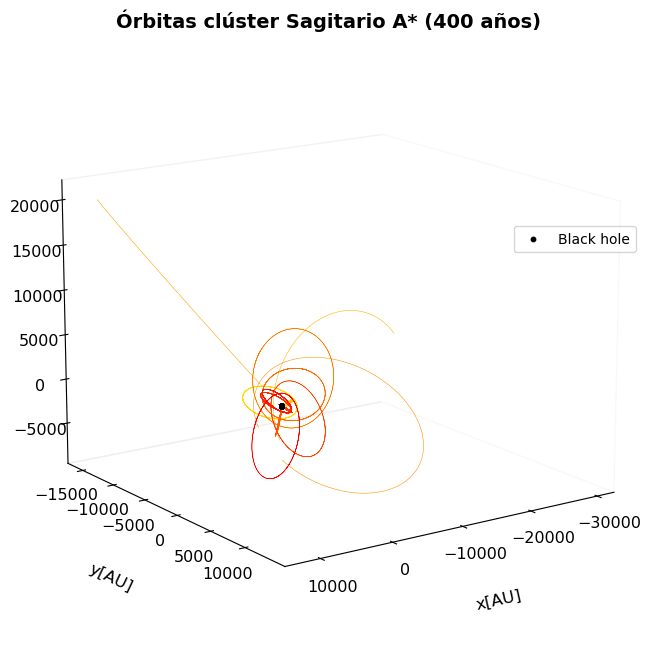

In [15]:
fig = plt.figure(figsize = (8,8))
ax = plt.axes(projection='3d')
ax.grid(False)

ax.set_title(f'Órbitas clúster Sagitario A* ({tf-t0} años)', fontweight = 'bold', fontsize = 14)

common_size = 12
common_lsize = 11.5
ax.set_xlabel('x[AU]', labelpad=20, fontsize = common_size)
ax.set_ylabel('y[AU]', labelpad=20, fontsize = common_size)
ax.set_zlabel('z[AU]', labelpad=20, fontsize = common_size)
ax.tick_params(axis='x', which='both', labelsize=common_lsize)
ax.tick_params(axis='y', which='both', labelsize=common_lsize)
ax.tick_params(axis='z', which='both', labelsize=common_lsize)

# ax.set_facecolor('black')
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

ax.scatter3D(solBH_verlet[:,0,0], solBH_verlet[:,0,1], solBH_verlet[:,0,2], label = 'Black hole', c = 'k', s = 10)

cmap = plt.get_cmap("autumn_r", 15)
col = [mpc.rgb2hex(cmap(i)) for i in range(cmap.N)]

for ii in range(1,len(dataBH[:,-1])):
    # ax.plot3D(solBH[:,ii,0], solBH[:,ii,1], solBH[:,ii,2], label = str(ii))
    ax.plot3D(solBH_verlet[:,ii,0], solBH_verlet[:,ii,1], solBH_verlet[:,ii,2], c = col[ii + 1], lw = .4)

ax.view_init(elev = 15, azim = 55)
ax.legend(loc = (.8,.65))
# plt.savefig('figures/sA*verlet.pdf')

Con este método de integración, la energía se comporta como

In [16]:
energyBH_verlet = np.zeros(solBH_verlet.shape[0])

for ii in range(solBH_verlet.shape[0]):
    energyBH_verlet[ii] = TotalEnergy(solBH_verlet[ii,:,:],dataBH[:,-1])

print(f'Initial energy: {energyBH_verlet[0]}')
print(f'Change in energy: {np.abs(energyBH_verlet[0] - energyBH_verlet[-1])} ({100*(np.abs(1-energyBH_verlet[-1]/energyBH_verlet[0])):.2e}%)')

Initial energy: -460128.30167210556
Change in energy: 3750.738885376253 (8.15e-01%)


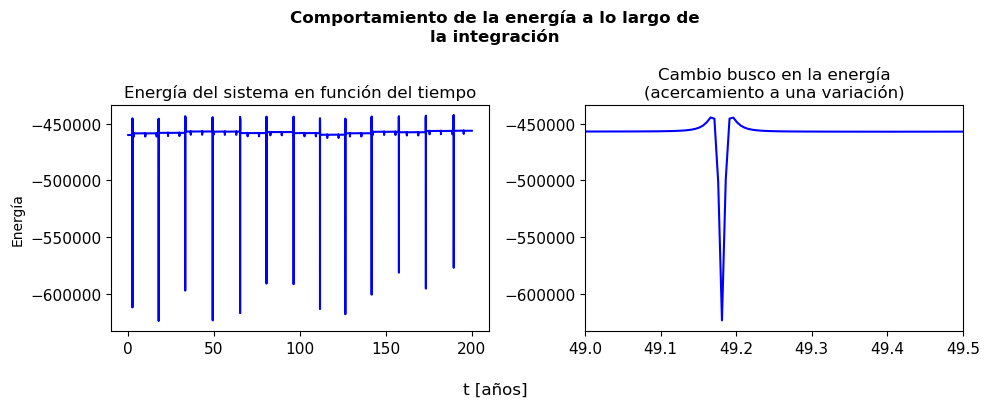

In [17]:
figeBH_verlet, axeBH_verlet = plt.subplots(1,2, figsize = (10,4))

figeBH_verlet.suptitle('Comportamiento de la energía a lo largo de\nla integración', fontweight = 'bold', fontsize = 12)
figeBH_verlet.supxlabel('t [años]')

axeBH_verlet[0].set_title('Energía del sistema en función del tiempo')
axeBH_verlet[0].set_ylabel('Energía')
axeBH_verlet[0].tick_params(axis='both', which='both', labelsize=11)
axeBH_verlet[0].plot(t_grid, energyBH_verlet, c = 'b')

axeBH_verlet[1].set_title('Cambio busco en la energía\n(acercamiento a una variación)')
axeBH_verlet[1].set_xlim(49,49.5)
axeBH_verlet[1].tick_params(axis='both', which='both', labelsize=11)
axeBH_verlet[1].plot(t_grid, energyBH_verlet, c = 'b')

plt.tight_layout()
# plt.savefig('figures/sA*verlet_energy.pdf')

La energía, aunque presenta variaciones bruscas de forma aproximadamente periódica, retoma rápidamente al valor inicialmente calculado, comportamiento propio de los métodos simplécticos. Con este comportamiento, tenemos que en nuestra implementación, la energía se sigue conservando, de forma similar a como lo hacía en la implementación usando RK4, con una variación en la energía del $0.815\%$ para la integración con Verlet, y una variación en la energía del $0.871\%$ para la integración con RK4.

Por otro lado, la integración usando el método simpléctico Verlet, implica una mejora de aproximadamente el $386\%$ en el tiempo de ejecución, respecto a la integración con RK4, como se puede comprobar con las mediciones obtenidas sobre los tiempos de ejecución (59.91 segundos para la integración RK4 frente a 15.51 segundos para la integración Verlet).